In [1]:
# import zipfile
# from pathlib import Path

# zip_path = Path('data/videos_noaudio.zip')
# extract_dir = zip_path.parent if zip_path.exists() else Path('data')

# if not zip_path.exists():
#     raise FileNotFoundError(f"Zip file not found: {zip_path}")

# extract_dir.mkdir(parents=True, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as z:
#     z.extractall(path=extract_dir)
#     extracted = z.namelist()

# print(f"Extracted {len(extracted)} items to {extract_dir}")

In [2]:
# %pip install ultralytics
# %pip install opencv-python #for cv2

# 1. Imports and Configuration

In [9]:
import os
import re
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
from typing import List, Tuple, Dict

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Hyperparameters
NUM_CLASSES = 3
SEQ_LEN = 32          # Length of the frame sequence to feed the model
FRAME_SIZE = 224      # Input size (224х224 as in ResNet)
FEATURE_DIM = 64      # Output of the CNN encoder
CHANNELS = [64, 64]   # TCN layers
KERNEL_SIZE = 3
DROPOUT = 0.1
BATCH_SIZE = 8
LR = 1e-3
EPOCHS = 10

# Mapping
CLASS_MAP = {'Rock': 0, 'Paper': 1, 'Scissor': 2}
INV_CLASS_MAP = {0: 'Rock', 1: 'Paper', 2: 'Scissor'}
WINNING_MOVE = {
    'Rock': 'Paper',
    'Paper': 'Scissor',
    'Scissor': 'Rock'
}

Using device: cuda


# 2. The Dataset Loader (Fixed for this current file structure)

In [10]:
class VideoFramesDataset(Dataset):
    def __init__(self, root_dir: str, seq_len: int = 16, augment: bool = False):
        self.root = Path(root_dir)
        self.seq_len = seq_len
        self.augment = augment
        
        # Transforms
        if augment:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)), # Bump resolution up
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15), # Rotates hand +/- 15 degrees
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((FRAME_SIZE, FRAME_SIZE)),
                transforms.ToTensor(),
            ])

        self.samples = self._parse_filesystem()

    def _parse_filesystem(self) -> List[Tuple[List[Path], int]]:
        """Parses the directory to group frames into video sequences."""
        samples = []
        # Regex to capture: (VideoID)_(FrameNumber).jpg
        # Example: 20251122_220625_720p20fps_nosound_095.jpg
        # Group 1 is the Video ID, Group 2 is the frame index.
        pattern = re.compile(r'(.+)_(\d+)\.(jpg|jpeg|png)$', re.IGNORECASE)

        for cls_name, label in CLASS_MAP.items():
            cls_dir = self.root / cls_name
            # Handle slight naming variations (e.g. Scissor vs Scissors) if necessary
            if not cls_dir.exists():
                # Fallback check for plurals or lowercase if folder names vary
                cls_dir = self.root / (cls_name + 's') 
                if not cls_dir.exists():
                    print(f"Warning: Directory for {cls_name} not found.")
                    continue

            # Group frames by video ID
            video_frames: Dict[str, List[Tuple[int, Path]]] = {}
            
            for img_path in cls_dir.glob('*'):
                match = pattern.match(img_path.name)
                if match:
                    vid_id = match.group(1)
                    frame_idx = int(match.group(2))
                    if vid_id not in video_frames:
                        video_frames[vid_id] = []
                    video_frames[vid_id].append((frame_idx, img_path))

            # Process grouped frames into sequences
            for vid_id, frames in video_frames.items():
                # Sort by frame index
                frames.sort(key=lambda x: x[0])
                paths = [p for _, p in frames]
                
                # We can create multiple sliding windows or just take the end
                # Here, we take the last SEQ_LEN frames to capture the gesture formation
                if len(paths) >= self.seq_len:
                    # Optional: sliding window for more data
                    # for i in range(len(paths) - self.seq_len + 1):
                    #     samples.append((paths[i : i+self.seq_len], label))
                    
                    # Simple version: Take the sequence
                    samples.append((paths[:self.seq_len], label)) 
                else:
                    # Pad if video is too short (repeat first frame)
                    padded = [paths[0]] * (self.seq_len - len(paths)) + paths
                    samples.append((padded, label))
                    
        print(f"Found {len(samples)} sequences.")
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        images = []
        for p in frame_paths:
            img = Image.open(p).convert('RGB')
            images.append(self.transform(img))
        
        # Stack: (Seq_Len, Channels, Height, Width)
        seq_tensor = torch.stack(images, dim=0)
        return seq_tensor, label

# 3. The Model (CNN + TCN)

In [11]:
# Try importing TCN, handle if not installed
try:
    from pytorch_tcn import TCN
except ImportError:
    print("pytorch-tcn not found. Please run: pip install pytorch-tcn")

import torchvision.models as models

class ResNetFrameEncoder(nn.Module):
    def __init__(self, feature_dim=64):
        super().__init__()
        # 1. Load a pre-trained ResNet18
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # 2. Remove the last layer (the ImageNet classifier)
        # ResNet18's feature layer (avgpool) outputs 512 features
        modules = list(resnet.children())[:-1] 
        self.backbone = nn.Sequential(*modules)
        
        # 3. Add a projection layer to get down to your TCN size (64)
        self.proj = nn.Linear(512, feature_dim)
        
        # Optional: Freeze early layers to speed up training if data is small
        # for param in list(self.backbone.children())[:6]:
        #     param.requires_grad = False

    def forward(self, x):
        # x shape: (B*T, 3, 128, 128)
        features = self.backbone(x)        # Output: (B*T, 512, 1, 1)
        features = features.flatten(1)     # Output: (B*T, 512)
        return self.proj(features)         # Output: (B*T, 64)
    
    
class GestureTCN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.encoder = ResNetFrameEncoder(feature_dim=FEATURE_DIM) 
        
        self.tcn = TCN(
            num_inputs=FEATURE_DIM,
            num_channels=CHANNELS,
            kernel_size=KERNEL_SIZE,
            dropout=DROPOUT,
            causal=True,
            input_shape='NCL' 
        )
        self.classifier = nn.Linear(CHANNELS[-1], num_classes)

    def forward(self, x, return_all_timesteps=False):
        # x: (Batch, Seq_Len, 3, H, W)
        b, t, c, h, w = x.shape
        x_flat = x.view(b * t, c, h, w)
        
        features = self.encoder(x_flat)      # (B*T, Feat)
        features = features.view(b, t, -1).permute(0, 2, 1) # (B, Feat, T) for TCN
        
        tcn_out = self.tcn(features)         # (B, Hidden, T)
        
        if return_all_timesteps:
            # Transpose to (B, T, Hidden) so Linear layer applies to every step
            tcn_out = tcn_out.permute(0, 2, 1) 
            return self.classifier(tcn_out)  # Returns (B, T, Num_Classes)
        else:
            # Standard training behavior (last step only)
            last_out = tcn_out[:, :, -1]
            return self.classifier(last_out) # Returns (B, Num_Classes)

# 4. Training Loop

In [12]:
def train_model(data_path='data/noaudio_ver1_cropped'):
    # Update this path to your actual path!
    
    dataset = VideoFramesDataset(data_path, seq_len=SEQ_LEN, augment=True)
    
    # Split Train/Val
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    model = GestureTCN(num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    
    print("Starting training...")
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for frames, labels in train_loader:
            frames, labels = frames.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(frames)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss/len(train_loader):.4f} | Acc: {100.*correct/total:.2f}%")
        
        for frames, labels in val_loader:
            frames, labels = frames.to(DEVICE), labels.to(DEVICE)
            
            # optimizer.zero_grad()
            outputs = model(frames)
            # loss = criterion(outputs, labels)
            # loss.backward()
            # optimizer.step()
            
            # train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        print(f"Epoch {epoch+1}/{EPOCHS} | Acc: {100.*correct/total:.2f}%")
        
    # Save the model
    torch.save(model.state_dict(), 'rps_tcn_model.pth')
    print("Model saved.")
    return model

# Uncomment to run training
model = train_model(data_path='data/noaudio_ver0_tracking')


Found 51 sequences.
Starting training...


Epoch 1/10 | Loss: 1.0633 | Acc: 40.00%
Epoch 1/10 | Acc: 41.18%
Epoch 2/10 | Loss: 0.6836 | Acc: 80.00%
Epoch 2/10 | Acc: 72.55%
Epoch 3/10 | Loss: 0.7479 | Acc: 80.00%
Epoch 3/10 | Acc: 76.47%
Epoch 4/10 | Loss: 0.6638 | Acc: 72.50%
Epoch 4/10 | Acc: 66.67%
Epoch 5/10 | Loss: 0.5817 | Acc: 80.00%
Epoch 5/10 | Acc: 70.59%
Epoch 6/10 | Loss: 0.6395 | Acc: 70.00%
Epoch 6/10 | Acc: 66.67%
Epoch 7/10 | Loss: 0.5636 | Acc: 90.00%
Epoch 7/10 | Acc: 80.39%
Epoch 8/10 | Loss: 0.3732 | Acc: 87.50%
Epoch 8/10 | Acc: 78.43%
Epoch 9/10 | Loss: 0.3433 | Acc: 87.50%
Epoch 9/10 | Acc: 78.43%
Epoch 10/10 | Loss: 0.2239 | Acc: 90.00%
Epoch 10/10 | Acc: 80.39%
Model saved.


# 5. The "Winning" Inference Logic

In [13]:
def predict_move(model, sequence_buffer):
    """
    Takes a sequence of frames (Tensor) and predicts the user's move.
    Then returns the move that BEATS the user.
    """
    model.eval()
    with torch.no_grad():
        # Input shape: (1, Seq_Len, 3, H, W)
        frames = sequence_buffer.to(DEVICE)
        logits = model(frames)
        probs = torch.softmax(logits, dim=1)
        
        # Get the predicted class (what the user is doing)
        confidence, pred_idx = torch.max(probs, 1)
        user_move = INV_CLASS_MAP[pred_idx.item()]
        
        # Logic to beat the user
        my_move = WINNING_MOVE[user_move]
        
        return user_move, my_move, confidence.item()

# Example usage (simulated):
# seq = torch.randn(1, 16, 3, 128, 128) # Replace with real camera buffer
# user_gesture, counter_move, conf = predict_move(model, seq)
# print(f"User is showing {user_gesture}. I play {counter_move} to win!")

# 6. Evalutaing

Loading data from: data/noaudio_ver0_tracking
Found 51 sequences.
Found 51 video sequences.
Weights loaded successfully.

Final Accuracy (at frame 32): 70.59%
The model did not reach 80% accuracy.


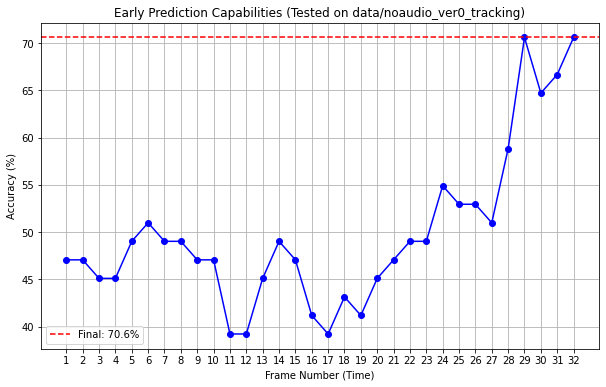

In [14]:
import matplotlib.pyplot as plt

def evaluate_on_new_data(model_path, data_path):
    print(f"Loading data from: {data_path}")
    
    # 1. Create Dataset for the NEW folder
    # We use augment=False because this is a test run
    test_ds = VideoFramesDataset(data_path, seq_len=SEQ_LEN, augment=False)
    test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)
    
    print(f"Found {len(test_ds)} video sequences.")

    # 2. Load Model
    model = GestureTCN(num_classes=NUM_CLASSES).to(DEVICE)
    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        print("Weights loaded successfully.")
    except FileNotFoundError:
        print("Error: Model file not found. Make sure you trained it first!")
        return

    model.eval()
    
    # 3. Metrics Storage
    # We want to know: "What is the accuracy at Frame 1? Frame 2? ... Frame 16?"
    correct_at_frame = [0] * SEQ_LEN
    total_samples = 0
    
    with torch.no_grad():
        for seq, labels in test_loader:
            seq = seq.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # Get output for ALL timesteps: Shape (Batch, 16, 3)
            logits_all_steps = model(seq, return_all_timesteps=True)
            
            # Convert to predictions
            preds_all_steps = logits_all_steps.argmax(dim=2) # Shape (Batch, 16)
            
            # Check accuracy for each timestep
            for t in range(SEQ_LEN):
                # How many in this batch got frame 't' correct?
                correct_at_frame[t] += (preds_all_steps[:, t] == labels).sum().item()
            
            total_samples += labels.size(0)

    # 4. Calculate Percentages
    accuracies = [ (c / total_samples) * 100 for c in correct_at_frame ]
    
    # 5. Report Results
    final_acc = accuracies[-1]
    print(f"\nFinal Accuracy (at frame {SEQ_LEN}): {final_acc:.2f}%")
    
    # Find "Early Prediction" point (e.g., when acc > 80%)
    early_point = next((i for i, x in enumerate(accuracies) if x > 80.0), None)
    if early_point:
        print(f"The model reaches 80% accuracy at Frame {early_point + 1}!")
    else:
        print("The model did not reach 80% accuracy.")

    # 6. Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, SEQ_LEN+1), accuracies, marker='o', linestyle='-', color='b')
    plt.axhline(y=final_acc, color='r', linestyle='--', label=f'Final: {final_acc:.1f}%')
    plt.title(f'Early Prediction Capabilities (Tested on {data_path})')
    plt.xlabel('Frame Number (Time)')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.xticks(range(1, SEQ_LEN+1))
    plt.legend()
    plt.show()

# --- RUN THE TEST ---
# Ensure 'rps_tcn_model.pth' exists (or whatever you named your saved model)
# Point to your NEW data folder
evaluate_on_new_data(model_path='rps_tcn_model.pth', data_path='data/noaudio_ver0_tracking')